<a href="https://colab.research.google.com/github/nam157/detect-license-plate-CNN---cv2-/blob/main/license_plate_detect_by_OpenCV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ĐỌC TỆP ẢNH TỪ THƯ MỤC

In [ ]:
IMAGE_SIZE = 200
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
img_dir = "/content/drive/MyDrive/GreenParking/images"
data_path = join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() 
X=[]
for f1 in files:
    img = cv2.imread(f1)
    X.append(np.array(img))

DÙNG MẠNG WPOD-NET CẮT BIỂN SỐ - SỬ DỤNG MÃ NGUỒN MỞ CÓ SẴN (NGUỒN THƯ VIỆN MÌ AI)

WPOD - Wraped Planer Object Detection Network. Mạng được thiết kế dựa trên ý tưởng của YOLO, SSD và STN (Spatial Tranformer Network). Trong khi các mạng YOLO và SSD chỉ trả về một hình chữ nhật bao quanh biển số xe mà không quan tâm đến không gian xung quanh biển số xe là như thế nào thì WPOD có thể trả về một vùng tứ giác bao quanh biển số xe và đưa biển số về hướng nhìn chính diện.

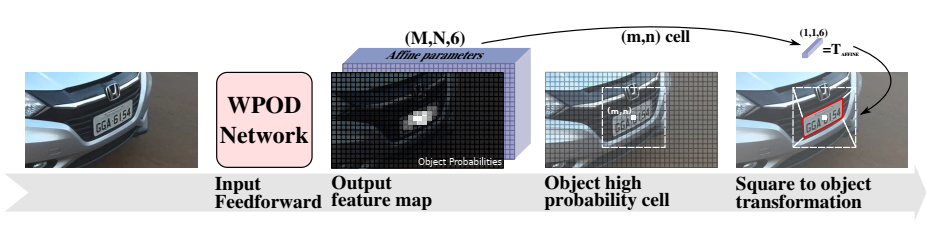

Từ 1 bức ảnh được chụp ảnh biển số thông qua quá trình làn truyền tiến mạng ta thu được output features map gồm 8 channels trong đó 2 channels đầu tiên là xác suất có/không có biển số xe và 6 channels còn lại là những thông số để tính toán ma trận transform (là ma trận được sử dụng để chuyển đổi góc nhìn của biển số xe).
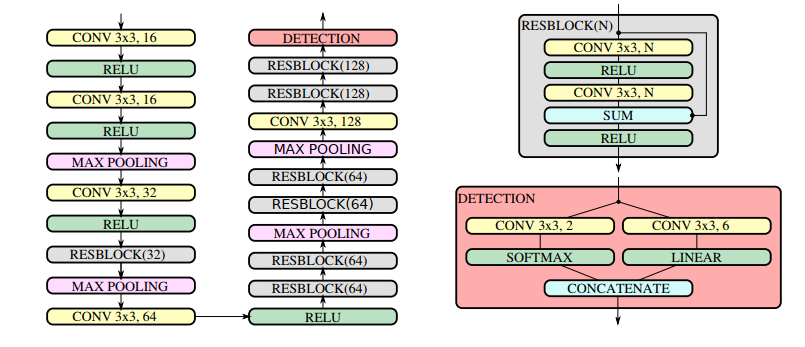

Kiến trúc mạng có 21 lớp convolutional Kiến trúc của mạng bao gồm 21 lớp convolutional trong đó có 14 lớp là nằm trong các khối residual. Tất cả các lớp đều dùng filter với kích thước 3x3 và dùng hàm kích hoạt là Relu ngoại trừ khối Detection. Khối Detection là khối đáng chú ý nhất trong kiến trúc mạng này.

Như đã đề cập ở trên thì output features map sẽ bao gồm 8 channels trong đó 2 channels đầu là xác suất có/không có đối tượng, 6 channels sau chứa các giá trị để tạo ra ma trận affine transform. Và để tạo ra được output features map như vậy thì khối Detection có 2 luồng riêng biệt, luồng thứ nhất dành cho việc tính toán xác suất có/không có đối tượng (2 channels đầu tiên của output features map) với luồng này thì sử dụng activations là softmax, luồng thứ 2 phục vụ cho việc tính toán các thông số để tạo ra ma trận transform với luồng này ta không sử dụng hàm kích hoạt hay nói cách khác hàm kích hoạt cho luồng này là hàm $ {f(x) = x}f(x)=x. Kết quả của 2 luồng nay sau đó sẽ được gộp với nhau để đưa ra output.

In [ ]:
# Load model LP detection
!git clone https://github.com/thangnch/MiAI_LP_Detection_2
from MiAI_LP_Detection_2 import lib_detection
wpod_net_path = "/content/MiAI_LP_Detection_2/wpod-net_update1.json"
wpod_net = lib_detection.load_model(wpod_net_path)

In [ ]:
plt.figure(figsize=(20,40))
c = []
count = 0
for i in range(len(X)):
  Dmax = 608
  Dmin = 288
  ratio = float(max(X[i].shape[:2])) / min(X[i].shape[:2])
  side = int(ratio*Dmin)
  bound_dim = min(side,Dmax)
  _,lpimg,lp_type = lib_detection.detect_lp(wpod_net,lib_detection.im2single(X[i]),bound_dim,lp_threshold=0.5)
  roi = lpimg[0]
  print("<----------------------------------------------------------->")
  count += 1
  print("-------->",count)
  c.append(lpimg[0])

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,20):
  plt.subplot(10,5,i+1)
  plt.axis('off')
  plt.imshow(c[i])

CHUYỂN TOÀN ẢNH VỀ ẢNH XÁM 

Chuyển ảnh về ảnh xám và sử dụng threshold để phát hiện các cạnh biển số và tách số và nền  
- 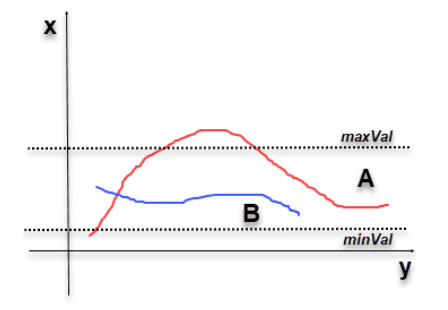

In [ ]:
binary_array = []
for i in range(len(c)):
  c[i] = cv2.convertScaleAbs(c[i],alpha = (255.0))
  gray = cv2.cvtColor(c[i],cv2.COLOR_BGR2GRAY)
 
  plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))
  binary = cv2.threshold(gray, 127, 255,cv2.THRESH_BINARY_INV)[1]
  binary_array.append(binary)    

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,30):
  plt.subplot(10,5,i+1)
  plt.axis('off')
  plt.imshow(binary_array[i])

In [ ]:
# Ham sap xep contour tu trai sang phai
def sort_contours(cnts):

    reverse = False
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# Dinh nghia cac ky tu tren bien so
char_list =  '0123456789ABCDEFGHKLMNPRSTUVXYZ'

# Ham fine tune bien so, loai bo cac ki tu khong hop ly
def fine_tune(lp):
    newString = ""
    for i in range(len(lp)):
        if lp[i] in char_list:
            newString += lp[i]
    return newString


TÁCH KÝ TỰ TRÊN BIỂN SỐ RA THÀNH DATA KÝ TỰ 

Xác định contours: Contour được hiểu đơn giản là một đường cong liên kết toàn bộ các điểm liên tục (dọc theo đường biên) mà có cùng màu sắc hoặc giá trị cường độ:
- Để độ chính xác cao thì ảnh chuyển ảnh nhị phân 
- sử dụng phương thức cv2.findContous:tìm đường viền trong hình ảnh có viền và giữ lại phần lớn nhất. Có 3 tham số trong hàm cv2.findContours(), đầu tiên là hình ảnh gốc, thứ 2 là phương pháp trích xuất contours, thứ 3 là phương pháp xấp xỉ contour. Kết quả trả ra là hình ảnh và contours. Trong đó contours là một list của toàn bộ các contours xác định trong hình ảnh. Mỗi một contour là một numpy array của các tọa độ  của các điểm biên trong object.
- Từ contour, ta sẽ xác định tọa độ góc trên bên trái và độ dài cạnh width, height của contour thông qua hàm cv2.boundingRect(). 

Tính toán các khu vực xung quanh các ký tự :
- Tỷ lệ cạnh (aspect Ratio): $$ aspectRatio = \frac{W}{H} $$
- Độ cô đặc (Solidity) : $$ solidity  = \frac{S_{contour}}{S_{w*h}}  $$
- Tỷ lệ chiều dài :  $$ heightRatio = \frac{H}{S_{area}} $$

In [ ]:
for i in range(len(binary_array)):
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  thre_mor = cv2.morphologyEx(binary_array[i], cv2.MORPH_DILATE, kernel3)
  cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  plate_info = ""
  for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    aspectRatio = w / float(h) # tỷ lệ rộng dài
    solidity = cv2.contourArea(c) / float(w * h) # tỷ lệ diện tích bao quanh 
    heightRatio = h / float(roi.shape[0]) # tỷ lệ chiều dài ký tự
    if 0.1 < aspectRatio < 1.0 and solidity > 0.1 and 0.35 < heightRatio < 2.0: 
      cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)
      curr_num = thre_mor[y:y+h,x:x+w]
      curr_num = cv2.resize(curr_num, (digit_w, digit_h),cv2.INTER_AREA)
      _,curr_num = cv2.threshold(curr_num, 99, 255, cv2.THRESH_BINARY)
      curr_num = np.array(curr_num,dtype=np.float32)
      cv2_imshow(curr_num[:5])
      data_.append(curr_num)
np.save("/content/alphas.npy", data_)

ĐỌC FILE ẢNH VÀ GÁN NHÃN CHO TỪNG KÝ TỰ

In [ ]:
import os
import numpy as np
import cv2
path = "/content/drive/MyDrive/data_classification/"
data = []


for fi in os.listdir(path):

    if fi == "0":
        label = 0
    elif fi == "1":
        label = 1
    elif fi == "2":
        label = 2
    elif fi == "3":
        label = 3
    elif fi == "4":
        label = 4
    elif fi == "5":
        label = 5
    elif fi == "6":
        label = 6
    elif fi == "7":
        label = 7
    elif fi == "8":
        label = 8
    elif fi == "9":
        label = 9  
    elif fi == "A":
        label = 65
    elif fi == "B":
        label = 66
    elif fi == "C":
        label = 67
    elif fi == "D":
        label = 68
    elif fi == "E":
        label = 69
    elif fi == "F":
        label = 70
    elif fi == "G":
        label = 71
    elif fi == "H":
        label = 72
    elif fi == "K":
        label = 75
    elif fi == "L":
        label = 76
    elif fi == "M":
        label = 77
    elif fi == "N":
        label = 78
    elif fi == "P":
        label = 80
    elif fi == "R":
        label = 82
    elif fi == "S":
        label = 83
    elif fi == "T":
        label = 84
    elif fi == "U":
        label = 85
    elif fi == "V":
        label = 86
    elif fi == "X":
        label = 88
    elif fi == "Y":
        label = 89
    elif fi == "Z":
        label = 90
    elif fi == 'BG':
        label = 31
    else:
        label = -1
        ValueError("Don't match file")

    img_fi_path = os.listdir(path + fi)
    for img_path in img_fi_path:
        %time img = cv2.imread(path + fi + "/" + img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (30,90), cv2.INTER_AREA)
        img = img.reshape((90, 30, 1))
        data.append((img, label))
np.save("/content/data_alphas_ver2.npy", data)

ĐỌC FILE ĐÃ LƯU TRƯỚC ĐÓ

In [ ]:
def get_digits_alpha_data(path):
    data = np.load(path, allow_pickle=True)
    total_nb_data = len(data)
    np.random.shuffle(data)
    data_train = []

    for i in range(total_nb_data):
        data_train.append(data[i])

    print("-------------DONE------------")
    print('The number of train digits data: ', len(data_train))

    return data_train

In [ ]:
data_digit  = get_digits_alpha_data("/content/drive/MyDrive/data_alphas.npy")

In [ ]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential

In [ ]:
img = []
lab = []
for i in range(len(data_digit)):
  img.append(data_digit[i][0])
  lab.append(data_digit[i][1])

In [ ]:
X = np.array(img)
y = np.array(lab)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

Để định nghĩa loss function, trước hết ta dùng one-hot encoding chuyển đổi label của ảnh từ giá trị
số sang vector cùng kích thước với output của model.

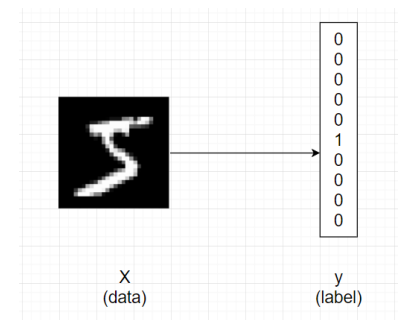

In [ ]:
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

In [ ]:
Y_train = to_categorical(y_train,32)

In [ ]:
# CNN model
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape = (90,30,1)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))

model.summary()

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
H = model.fit(x_train,Y_train,validation_split=0.15,batch_size = 128,epochs = 50)

In [ ]:
!sudo pip install h5py

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# Vẽ đồ thị loss, accuracy của training set và validation set
fig = plt.figure()
numOfEpoch = 50
plt.plot(np.arange(0, 50), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()


In [ ]:
y_predict = model.predict(x_test[2].reshape(1,90,30,1))

In [ ]:
plt.imshow(x_test[2].reshape(90,30))

In [ ]:
np.argmax(y_predict)

DETECT LICENSE PLATE

In [ ]:
import cv2
# img_path = "/content/drive/MyDrive/GreenParking/images/0000_08244_b.jpg"
# img_path = "/content/drive/MyDrive/GreenParking/images/0006_06035_b.jpg"
# img_path = "/content/drive/MyDrive/GreenParking/images/0054_06669_b.jpg"
img_path = '/content/drive/MyDrive/GreenParking/images/0038_08198_b.jpg'
# Đọc file ảnh đầu vào
Ivehicle = cv2.imread(img_path)

# Kích thước lớn nhất và nhỏ nhất của 1 chiều ảnh
Dmax = 608
Dmin = 288

# Lấy tỷ lệ giữa W và H của ảnh và tìm ra chiều nhỏ nhất
ratio = float(max(Ivehicle.shape[:2])/min(Ivehicle.shape[:2]))
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

_ , LpImg, lp_type =  lib_detection.detect_lp(wpod_net, lib_detection.im2single(Ivehicle), bound_dim, lp_threshold=0.5)

digit_w = 30 
digit_h = 90 

data_ = []
LpImg[0] = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
roi = LpImg[0]
# Chuyen anh bien so ve gray
gray = cv2.cvtColor( LpImg[0], cv2.COLOR_BGR2GRAY)
# Ap dung threshold de phan tach so va nen
binary = cv2.threshold(gray, 127, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
plt.imshow(binary)



In [ ]:
# X = cv2.imread("/content/drive/MyDrive/GreenParking/images/0000_05696_b.jpg")
# digit_w = 30 
# digit_h = 90 
# Dmax = 608
# Dmin = 288
# ratio = float(max(X.shape[:2])/min(X.shape[:2]))
# side = int(ratio * Dmin)
# bound_dim = min(side,Dmax)
# _,lpimg,lp_type = lib_detection.detect_lp(wpod_net,lib_detection.im2single(X),bound_dim,lp_threshold=0.5)
# roi = lpimg[0]
# plt.figure()
# plt.imshow(lpimg[0])
# lpimg[0] = cv2.convertScaleAbs(lpimg[0],alpha=(255.0))
# gray = cv2.cvtColor(lpimg[0],cv2.COLOR_BGR2GRAY)
# binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)[1]
# plt.figure()
# plt.imshow(binary)

In [ ]:
# Segment kí tự
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# contours , _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
data = []
for c in sort_contours(cont):
  (x,y,w,h) = cv2.boundingRect(c)
  aspectRatio = w / float(h) # tỷ lệ rộng dài
  solidity = cv2.contourArea(c) / float(w * h) # tỷ lệ diện tích bao quanh 
  heightRatio = h / float(roi.shape[0]) # tỷ lệ chiều dài ký tự
  if 0.1 < aspectRatio < 1.0 and solidity > 0.1 and 0.35 < heightRatio < 2.0: 
    img = cv2.rectangle(roi,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(img)
    curr = thre_mor[y:y+h,x:x+w]
    curr = cv2.resize(curr, (30, 90),cv2.INTER_AREA)
    _,curr_num = cv2.threshold(curr, 99, 255, cv2.THRESH_BINARY)
    curr_num = curr_num.reshape(90,30,1)
    data.append((curr,(y,x)))
    cv2_imshow(curr)

In [ ]:
# # Sắp xếp các contour theo diện tích giảm dần:
# data = []
# area_cnt = [cv2.contourArea(cnt) for cnt in cont]
# area_sort = np.argsort(area_cnt)[::-1]
# mask = np.zeros(binary.shape, np.uint8)
# for c in area_sort[1:10]:
#   cnt = cont[c]
#   (x, y, w, h) = cv2.boundingRect(cnt)

#   img = cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)
#   plt.imshow(img)

#   curr = thre_mor[y:y+h,x:x+w]
#   curr = cv2.resize(curr, (30, 90),cv2.INTER_AREA)
#   _,curr_num = cv2.threshold(curr, 99, 255, cv2.THRESH_BINARY)
#   curr_num = curr_num.reshape(90,30,1)
#   data.append((curr,(y,x)))
#   cv2_imshow(curr)


In [ ]:
ALPHA_DICT = {10: 'A', 11: 'B', 12: 'C', 13: '0', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L', 20: 'M', 21: 'N', 22: 'P',
              23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z', 0: '0', 1: '1', 2: '2', 3: '3',
              4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 31: "Background"}

In [ ]:
characters = []
coordinates = []
for char, coordinate in data:
    characters.append(char)
    coordinates.append(coordinate)

In [ ]:
characters = np.array(characters)
characters = characters.reshape(-1,90,30,1)
result = model.predict(characters)
result_idx = np.argmax(result, axis=1)
candidates = []
for i in range(len(result_idx)):
  if result_idx[i] == 31:  
      continue
  candidates.append((ALPHA_DICT[result_idx[i]], coordinates[i])) 

In [ ]:
result_idx

In [ ]:
candidates

In [ ]:
candidates[0][1][0]

In [ ]:
for candidate, coordinate in candidates:
  print(candidate)
  print(coordinate)

In [ ]:
def take_second(s):
    return s[1]

In [ ]:
first_line = []
second_line = []
for candidate, coordinate in candidates:
  if candidates[0][1][0]  > coordinate[0]:
    first_line.append((candidate, coordinate[1]))
  else:
    second_line.append((candidate, coordinate[1]))
first_line = sorted(first_line, key=take_second)
second_line = sorted(second_line, key=take_second)

In [ ]:
first_line

In [ ]:
second_line

In [ ]:
if len(second_line) == 0: 
            license_plate = "".join([str(ele[0]) for ele in first_line])
else: 
            license_plate = "".join([str(ele[0]) for ele in first_line]) + "-" + "".join([str(ele[0]) for ele in second_line])
license_plate

In [ ]:
cv2.putText(Ivehicle,license_plate,(50, 50), cv2.FONT_HERSHEY_PLAIN, 4.0, (255, 215, 0), lineType=cv2.LINE_AA)
import matplotlib.pyplot as plt
plt.imshow(Ivehicle)
print("Biển số xe:",license_plate)